# 0. Введение и описание датасета

- Датасет взят отсюда: https://media.xiph.org/video/derf/. RnD по видеокомпрессии он часто используется для бенчмаркинга алгоритмов. Внизу web-страницы есть разные варианты датасетов, для тестов был взят objective-1-fast. 

- Датасет представляет собой выборку из коротких видео ($~10^2$ фреймов) с разными разрешениями. В них, как правило, нет смены сцены, а значит, можно упростить задачу при тестировании различных подходов для видеокомпрессии. 

- Данные в raw формате yuv420 (.y4m, в отличии от .yuv, есть хэдер с метаданными). Ссылки: https://ru.wikipedia.org/wiki/YUV, 

- Используется opencv-python для загрузки-обработки-сохранения видео.

- В качестве backend-а для i/o используется библиотека ffmpeg. Бинарники для Windows лежат в корне проекта. Для Linux-а нужно ставить отдельно.

- Тензорные разложения делаются с помощью of-the-shelf имплементаций из библиотеки tensorly. Из плюсов, она может использовать PyTorch в качестве backend-a => Можно проводить расчеты на GPU (не реализовано) 

- На текущий момент не было найдено способа сохранять видео обратно в .y4m. Для этого нужно разбираться с CLI ffmpeg (его обертка в opencv этого сделать не позволяет). В текущей реализации, для корректной работы необходимо использовать расширение .avi для сохраняемого файла. При этом формат хранения фреймов видео останется прежним. Следует учитывать, что при конверсии yuv420 - RGB24 - yuv420 есть незначительные потери. Они минимальны и не влияют существенно на результат.

# 1. Чтение, визуализация и запись данных

In [40]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['animation.ffmpeg_path'] = r'ffmpeg/bin/ffmpeg.exe'

In [41]:
LOAD_FNAME = "data/Netflix_PierSeaside_1920x1080_60fps_8bit_420_60f.y4m"
SAVE_FNAME = "compressed_data/Netflix_PierSeaside_1920x1080_60fps_8bit_420_60f.avi"

### 1.1. Загрузка видео в массив numpy

In [42]:
from cvtcomp.utils import load_video_to_numpy

video, fourcc, fps, size = load_video_to_numpy(LOAD_FNAME)

In [43]:
video.shape

(60, 1080, 1920, 3)

 Так можно посмотреть на fourcc исходного видео. https://en.wikipedia.org/wiki/FourCC

In [44]:
import struct
print("FOURCC is '%s'" % struct.pack("<I", int(fourcc)))

FOURCC is 'b'I420''


### 1.2. Визуализация

In [45]:
from cvtcomp.utils import play_video

%matplotlib inline

play_video(video, fps=20)

### 1.3. Сохранение видео в raw формате

In [46]:
from cvtcomp.utils import save_video_from_numpy

save_video_from_numpy(SAVE_FNAME, video, fourcc, fps, size, color=True)

### 1.4. Тесты на потери при загрузки/сохранении

Следует учитывать, что есть потери при конверсии y4m -> rgb24 -> y4m 

In [47]:
video, fourcc, fps, size = load_video_to_numpy(LOAD_FNAME)
save_video_from_numpy(SAVE_FNAME, video, fourcc, fps, size, color=True)
video_new, _, _, _ = load_video_to_numpy(SAVE_FNAME) 

print(f"RMSE: {(((video_new - video)**2).sum() / video_new.size)**0.5}")

RMSE: 2.067145082840086


In [48]:
from cv2 import PSNR

print(f"PSNR = {PSNR(video_new, video)} dB")

video.shape

PSNR = 41.82338443447218 dB


(60, 1080, 1920, 3)

# 2. Тестирование подходов к видеокомпрессии на основе тензорных разложений

In [49]:
LOAD_FNAME = "data/Netflix_PierSeaside_1920x1080_60fps_8bit_420_60f.y4m"
COMPRESSED_VIDEO_FNAME = 'compressed_data/compressed_video.ctv'

## 2.1 Разложение Таккера

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from cvtcomp.base import TensorVideo
from cvtcomp.utils import load_video_to_numpy, play_video
plt.rcParams['animation.ffmpeg_path'] = r'ffmpeg/bin/ffmpeg.exe'

video, fourcc, fps, size = load_video_to_numpy(LOAD_FNAME)

tensor_video = TensorVideo(compression_type='tucker', quality=0.2, chunk_size=30, decoded_data_type=np.uint8)

tensor_video.encode(video)

restored_video = tensor_video.decode()

In [51]:
play_video(video, fps=fps / 2)

In [52]:
play_video(restored_video, fps=fps / 2)

### 2.2 TT-SVD

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from cvtcomp.base import TensorVideo
from cvtcomp.utils import load_video_to_numpy, play_video
plt.rcParams['animation.ffmpeg_path'] = r'ffmpeg/bin/ffmpeg.exe'

video, fourcc, fps, size = load_video_to_numpy(LOAD_FNAME)

tensor_video = TensorVideo(compression_type='tt', quality=0.2, chunk_size=30, decoded_data_type=np.uint8)

tensor_video.encode(video)

restored_video = tensor_video.decode()

In [54]:
play_video(video, fps=fps / 2)

In [55]:
play_video(restored_video, fps=fps / 2)

### 2.3 Использование опорного кадра и сжатие остатков (разностей) для частей видео


Подход вычитанием опорного кадра и компрессии остатков используется в h264 кодеке. Следует проверить, улучшит ли он качество видео при сжатии для используемых форматов хранения сжатого видео

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from cvtcomp.base import TensorVideo
from cvtcomp.utils import load_video_to_numpy, play_video, delete_reference_frame, restore_from_reference_frame
plt.rcParams['animation.ffmpeg_path'] = r'ffmpeg/bin/ffmpeg.exe'

video, fourcc, fps, size = load_video_to_numpy(LOAD_FNAME)
substracted_video, ref_frame = delete_reference_frame(video)

tensor_video = TensorVideo(compression_type='tucker', quality=0.4, chunk_size=60, decoded_data_type=np.uint8)
tensor_video.encode(substracted_video)


restored_video = restore_from_reference_frame(tensor_video.decode(), ref_frame)

play_video(restored_video, fps= fps/2)

- Оба подхода работают 
- "Наивная" реализация подхода с компрессией остатков не принесла желаемого результата
- Для дальнейшего улучшения качества компрессии необходим аналитический рассчет рангов тензорных разложений.

### 2.3 Сохранение видео в сжатом формате

In [57]:
tensor_video.save(COMPRESSED_VIDEO_FNAME, fps=30)

### 2.4 Загрузка видео из сжатого формата и его воспроизведение

In [58]:
loaded_tensor_video = TensorVideo().load(COMPRESSED_VIDEO_FNAME)
play_video(loaded_tensor_video.decode(), fps = loaded_tensor_video.fps / 2)

## 3. Оценка качества работы алгоритмов по всему датасету

In [59]:
from cvtcomp.utils import compute_metrics_dataset

def get_metrics_different_qualities(folderpath, compression_type='tt', chunk_size=30, qs=[0.05, 0.10, 0.25, 0.50]):
    
    result = np.array([compute_metrics_dataset(folderpath,
                                                   compression_type=compression_type,
                                                   chunk_size=chunk_size,
                                                   quality=q) for q in qs])
    
    return result[:, 0], result[:, 1], result[:, 2] # CR, PSNR, SSIM

In [60]:
# Получаем  СR, PSNR, SSIM для одного значения quality
compute_metrics_dataset("data/", compression_type='tt', chunk_size=30, quality=0.05)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [35:17<00:00, 70.57s/it]


(0.0015922768198817696, 20.58268698685068, 0.5311629692624257)

In [61]:
cr_tt, psnr_tt, ssim_tt = get_metrics_different_qualities(
    'data/',
    compression_type='tt',
    chunk_size=30,
    qs=[0.05, 0.1, 0.25, 0.5]
)

print(f"cr_tt: {cr_tt}\n psnr_tt: {psnr_tt}, \n ssim_tt: {ssim_tt}")

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [56:44<00:00, 113.49s/it]

cr_tt: [0.00159228 0.00419016 0.01550323 0.05111815]
 psnr_tt: [20.58268707 23.64561954 27.03482392 31.00461846], 
 ssim_tt: [0.53116296 0.61776849 0.75519975 0.87608065]


In [62]:
cr_tucker, psnr_tucker, ssim_tucker = get_metrics_different_qualities(
    'data/',
    compression_type='tucker',
    chunk_size=30,
    qs=[0.05, 0.1, 0.25, 0.5]
)

print(f"cr_tucker: {cr_tucker}\n psnr_tucker: {psnr_tucker} \n ssim_tucker: {ssim_tucker}")

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [1:31:10<00:00, 182.34s/it]

cr_tucker: [0.00111307 0.00264516 0.0084812  0.0555098 ]
 psnr_tucker: [20.5714489  23.79934628 27.44815897 32.07706169] 
 ssim_tucker: [0.52945978 0.62165379 0.77088834 0.90128288]


#### CR - PSNR

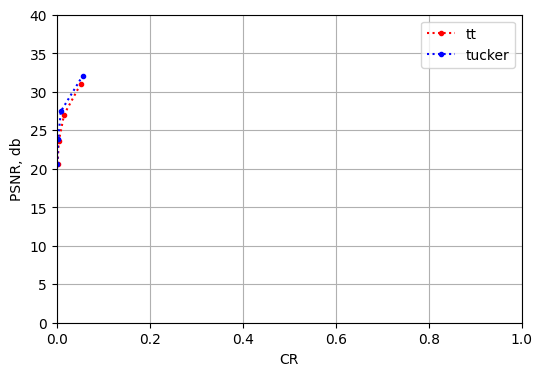

In [63]:
plt.figure(figsize=(6,4))
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 40])
plt.xlabel("CR")
plt.ylabel("PSNR, db")

plt.plot(cr_tt, psnr_tt, "r:.", label="tt")
plt.plot(cr_tucker, psnr_tucker, "b:.", label="tucker")
plt.legend()

#### CR - SSIM

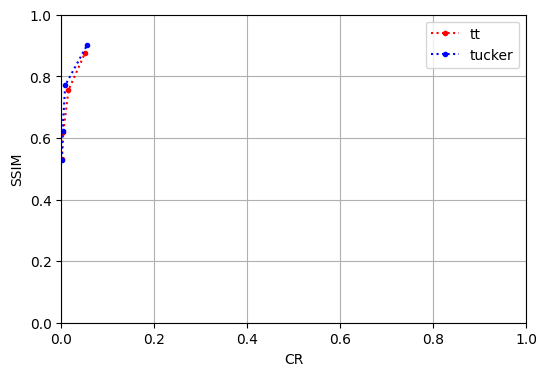

In [64]:
plt.figure(figsize=(6,4))
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("CR")
plt.ylabel("SSIM")

plt.plot(cr_tt, ssim_tt, "r:.", label="tt")
plt.plot(cr_tucker, ssim_tucker, "b:.", label="tucker")
plt.legend()

### 4. Тесты аналитического подбора рангов TTSVD с использованием нормы Фробениуса. 

Базовая реализация TTSVD адаптирована из следующей работы: https://github.com/azamat11235/NLRTA

При каждом tSVD ранг выбирается так чтобы rMSE(s_r^2) / rMSE(s_full^2) > 1 - (1 - quality) / (len(video.shape) - 1)

In [65]:
import numpy as np

def unfold(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1))


def truncated_svd(matrix, quality):
    
    u, s, vh = np.linalg.svd(matrix, full_matrices=False)
    s_remaining = 0.0
    s_total = np.sqrt(np.sum(s**2))
    for ii in range(s.size - 1, -1, -1):
        s_remaining += s[ii]**2
        if np.sqrt(s_remaining) / s_total > 1 - quality:
            r = ii + 1
            break
            
    return u[:, :r], (s[:r] * vh[:r, :].T).T, r


def fold(unfolded_tensor, mode, shape):
    full_shape = list(shape)
    mode_dim = full_shape.pop(mode)
    full_shape.insert(0, mode_dim)
    return np.moveaxis(np.reshape(unfolded_tensor, full_shape), 0, mode)


def mode_product(tensor, matrix, mode):
    if tensor.shape[mode] != matrix.shape[0]:
        raise RuntimeError(f'tensor.shape[{mode}] != matrix.shape[0]')
    new_shape = list(tensor.shape)
    new_shape[mode] = matrix.shape[1]
    tensor_mode = unfold(tensor, mode)
    return fold(matrix.T @ tensor_mode, mode, new_shape)


def TTSVD(tensor, quality):
    n = np.array(tensor.shape)
    G_list = []
    single_svd_decomp_quality = 1 - (1 - quality) * (1.0 / (len(tensor.shape) - 1))
    G = tensor.copy()
    G0 = unfold(G, 0)
    u, vh, r_prev = truncated_svd(G0, single_svd_decomp_quality)
    G_list.append(u)
    for k in range(1, len(tensor.shape)-1):
        #print(u.shape, vh.shape, r_prev)
        vh = vh.reshape(r_prev*n[k], np.prod(n[k+1:]))
        u, vh, r = truncated_svd(vh, single_svd_decomp_quality)
        r_cur = min(r, vh.shape[0])
        u = u.reshape(r_prev, n[k], r_cur)
        G_list.append(u)
        r_prev = r
        
    G_list.append(vh)
    G_list[0] = np.expand_dims(G_list[0], 0)
    G_list[-1] = np.expand_dims(G_list[-1], -1)
    
    return G_list

In [66]:
from cvtcomp.base import tt_decode
from cvtcomp.utils import play_video, load_video_to_numpy
import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = r'ffmpeg/bin/ffmpeg.exe'

compressed_video = TTSVD(video, 0.85)
restored_video = tt_decode(compressed_video)
restored_video[restored_video < 0.0] = 0.0
restored_video[restored_video > 255.0] = 255.0
restored_video = restored_video.astype(np.uint8)

print([x.shape for x in compressed_video])

[(1, 60, 26), (26, 1080, 195), (195, 1920, 2), (2, 3, 1)]


In [67]:
play_video(restored_video, fps = fps/2)

In [68]:
from cv2 import PSNR

print(f" CR: {sum([x.nbytes for x in compressed_video]) / video.nbytes}, PSNR: {PSNR(video, restored_video)}") 

 CR: 0.1334440586419753, PSNR: 27.29710464907923


In [ ]:
import os

for file in os.listdir()